In [6]:
pip install --upgrade pip


  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   -- ------------------------------------- 0.1/2.1 MB 1.8 MB/s eta 0:00:02
   ------------- -------------------------- 0.7/2.1 MB 6.7 MB/s eta 0:00:01
   ------------------------------------ --- 1.9/2.1 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 12.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [7]:
pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow as tf
import os

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.list_physical_devices('GPU')

[]

### Load Data

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

In [14]:
data = tf.keras.utils.image_dataset_from_directory('data', image_size =(200, 200), labels='inferred') 
# 200 car images plus petites, 256 par défaut

Found 69238 files belonging to 4 classes.


In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()

In [17]:
batch[0].shape

(32, 200, 200, 3)

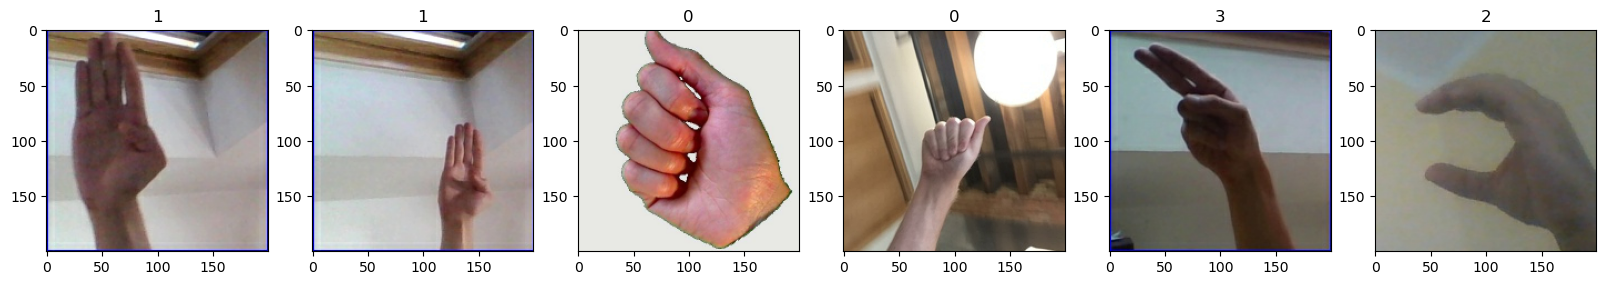

In [18]:
fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    # Classe 0 = A, Classe 1 = B, Classe 2 = C, Classe 3 = H

### Scale Data

In [19]:
data = data.map(lambda x,y: (x/255.0, y)) #Image = x, y = label

In [20]:
data.as_numpy_iterator().next()

(array([[[[0.        , 0.00392157, 0.9529412 ],
          [0.00784314, 0.01176471, 0.95686275],
          [0.03529412, 0.        , 0.9529412 ],
          ...,
          [0.        , 0.        , 0.93333334],
          [0.        , 0.        , 0.94509804],
          [0.        , 0.01176471, 0.9607843 ]],
 
         [[0.        , 0.00784314, 0.9607843 ],
          [0.02352941, 0.01960784, 0.9137255 ],
          [0.03529412, 0.        , 0.79607844],
          ...,
          [0.02745098, 0.02352941, 0.7372549 ],
          [0.03137255, 0.03529412, 0.8352941 ],
          [0.00392157, 0.01568628, 0.85882354]],
 
         [[0.        , 0.        , 0.95686275],
          [0.02745098, 0.01568628, 0.8039216 ],
          [0.        , 0.        , 0.44313726],
          ...,
          [0.21568628, 0.20392157, 0.4745098 ],
          [0.16470589, 0.15294118, 0.6666667 ],
          [0.03529412, 0.02745098, 0.65882355]],
 
         ...,
 
         [[0.02745098, 0.        , 0.9607843 ],
          [0.03137

In [21]:
scaled_iterator = data.as_numpy_iterator().next()

In [22]:
batch = scaled_iterator

In [23]:
batch[0].max()

1.0

### Split Data

In [24]:
len(data)

2164

In [25]:
train_size = int(len(data)*.7) #70%
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [26]:
train_size

1514

In [27]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Build Deep Learning Model 

In [28]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [30]:
model = Sequential()

In [31]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(200,200,3))) 
#relu : convertir output convolution vers fonction positives
model.add(MaxPooling2D()) #reduction données par environ 2

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#Couche de sortie
model.add(Flatten()) 
model.add(Dense(200, activation='relu'))
model.add(Dense(4, activation='softmax')) 
# 4 sera ici le nombre de fonctions, ici selon le sigmoid ( Representant nb classes )

In [32]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 16)        0

### Train

In [34]:
logdir='logs'

In [35]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
1514/1514 [==============================] - 696s 458ms/step - loss: 0.2133 - accuracy: 0.9201 - val_loss: 0.0551 - val_accuracy: 0.9884
Epoch 2/15
1514/1514 [==============================] - 636s 420ms/step - loss: 0.0271 - accuracy: 0.9923 - val_loss: 0.0375 - val_accuracy: 0.9918
Epoch 3/15
1514/1514 [==============================] - 611s 403ms/step - loss: 0.0148 - accuracy: 0.9960 - val_loss: 0.0427 - val_accuracy: 0.9919
Epoch 4/15
1514/1514 [==============================] - 650s 429ms/step - loss: 0.0096 - accuracy: 0.9977 - val_loss: 0.0284 - val_accuracy: 0.9945
Epoch 5/15
1514/1514 [==============================] - 5029s 3s/step - loss: 0.0071 - accuracy: 0.9985 - val_loss: 0.0250 - val_accuracy: 0.9954
Epoch 6/15
1514/1514 [==============================] - 585s 386ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0374 - val_accuracy: 0.9944
Epoch 7/15
1514/1514 [==============================] - 593s 391ms/step - loss: 0.0038 - accuracy: 0.9990 - val_lo

### Plot Perf 

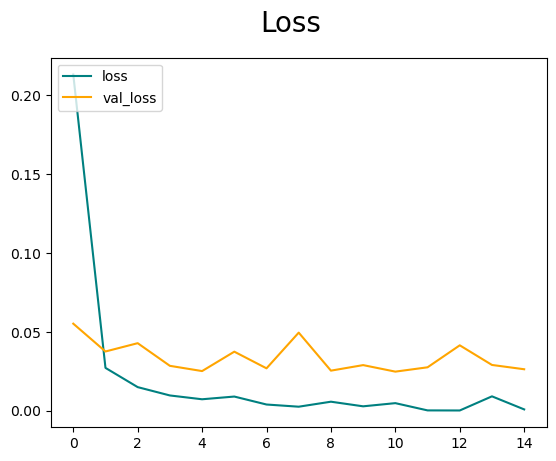

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

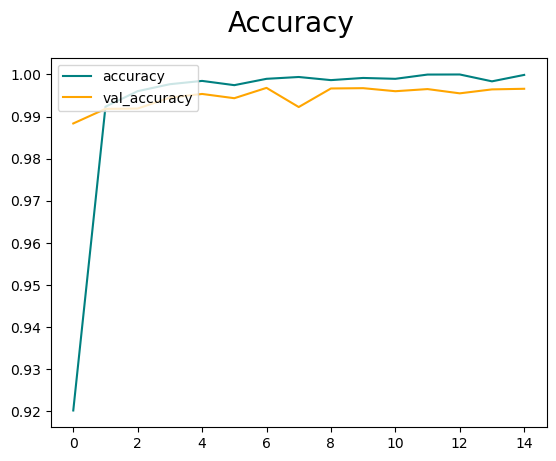

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluation 

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    
    predicted_classes = []
    for predictions in yhat:
        class_predictions = []  # Pour stocker les classes prédites pour chaque élément de la batch
        for prediction in predictions:
            if prediction <= 0.5:
                class_predictions.append(0)  # A
            elif prediction <= 1.5:
                class_predictions.append(1)  # B
            elif prediction <= 2.5:
                class_predictions.append(2)  # C
            else:
                class_predictions.append(3)  # H
        predicted_classes.append(class_predictions)

    predicted_classes = np.array(predicted_classes)
    correct_predictions = np.sum(predicted_classes == y)
    total_predictions = len(y)

    accuracy_manual = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy_manual}")

1/1 [==============================] - 0s 412ms/step
Accuracy: 0.0
1/1 [==============================] - ETA: 0s

C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_8016\2734304533.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct_predictions = np.sum(predicted_classes == y)


1/1 [==============================] - 0s 110ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 116ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 103ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 103ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 115ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 107ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 104ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 106ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 95ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 95ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 109ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 105ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 114ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 122ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 129ms/step
Accuracy: 0

1/1 [==============================] - 0s 99ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 103ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 100ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 97ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 106ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 98ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 102ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 103ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 117ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 105ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 107ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 107ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 104ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 102ms/step
Accuracy: 0.0
1/1 [==============================] - 0s 110ms/step
Accuracy: 0.

In [42]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# Test

In [43]:
import cv2

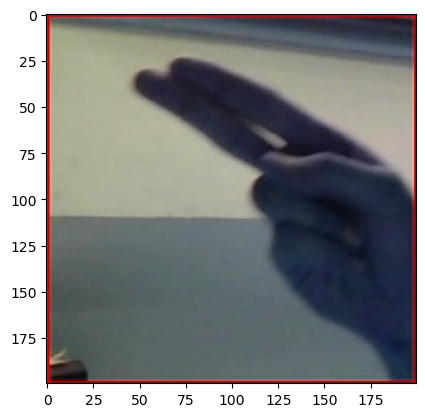

In [45]:
img = cv2.imread('H_test.jpg')
plt.imshow(img)
plt.show()

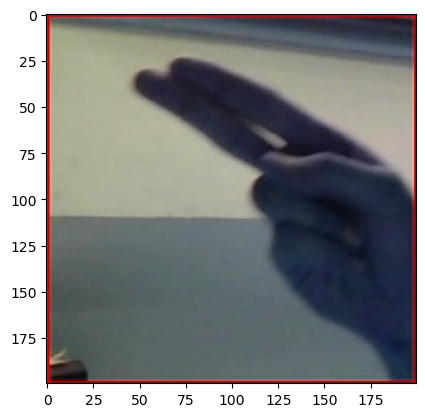

In [46]:
resize = tf.image.resize(img, (200,200))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 90ms/step


In [48]:
yhat

array([[2.85311359e-14, 2.55859604e-19, 1.20409125e-17, 1.00000000e+00]],
      dtype=float32)

In [49]:
predicted_class_index = np.argmax(yhat)
classes = ['A', 'B', 'C', 'H']
predicted_class = classes[predicted_class_index]

print(f'Predicted class is {predicted_class}')

Predicted class is H


In [50]:
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join('models','imageclassifier.h5'))

C:\Users\Lorenzo\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
new_model = load_model('imageclassifier.h5')

OSError: No file or directory found at imageclassifier.h5

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))